In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import pickle
import matplotlib
matplotlib.use('TkAgg')

%matplotlib inline
#%matplotlib qt

/home/ubuntu/anaconda3/envs/udacitypython3/lib/python3.5/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
def img_binary(img, s_thresh=(90, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    r_channel = img[:,:,0]
    
    #Grayscale image
    gray= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Sobel x
    sobelx = cv2.Sobel(r_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(r_channel)
    s_binary[(r_channel >= s_thresh[0]) & (r_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    #combine the two binary threholds.
    combine_binary = np.zeros_like(sxbinary)
    combine_binary[(s_binary ==1)| (sxbinary==1)] = 1
    return combine_binary 




def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    
    # 1) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 2) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 3) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # 4) Create a mask of 1's where the scaled gradient magnitude
    # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 5) Return this mask as your binary_output image
    return sxbinary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    binary_output = np.zeros_like(gradmag)
    # Apply threshold
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    with np.errstate(divide='ignore', invalid='ignore'):
        absgraddir = np.absolute(np.arctan(sobely/sobelx))
        binary_output =  np.zeros_like(absgraddir)
        # Apply threshold
        binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

def color_threshold(image, sthresh=(0,255), vthresh=(0,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])  ] = 1

    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= vthresh[0]) & (v_channel <= vthresh[1])  ] = 1

    output = np.zeros_like(s_channel)
    output[(s_binary == 1) & (v_binary == 1)] = 1
    return output


# Retuns binary image based on thresholding functions
def get_binary_image(image):
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    
    light_mask = np.zeros_like(L)
    #light_mask[(S >= 5) & (L >= 130)] = 1
    light_mask[((S >= 20) & (S<= 255)) & ((L >= 25) & (L<= 255))] = 1
    
    
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx_l = abs_sobel_thresh(L, orient='x', sobel_kernel=ksize, thresh=(25, 100))
    gradx_s = abs_sobel_thresh(S, orient='x', sobel_kernel=ksize, thresh=(10, 100))
    
    combined = np.zeros_like(gradx_s)
    # For some images S channel works better, while for others L channel does
    # Mix results from either channels
    combined[((gradx_l == 1) | (gradx_s == 1)) & (light_mask == 1)] = 1
    
    return combined

'''

def final_threshold(img):

    s_channel = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]
    l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]
    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]   

    # Threshold color channel
    s_thresh_min = 90
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    b_thresh_min = 155
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    l_thresh_min = 225
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    #color_binary = np.dstack((u_binary, s_binary, l_binary))
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(s_binary == 1) | (b_binary == 1)] = 1
    return combined_binary


def pipeline(img):
    # undistort the image 
    img = cv2.undistort(img,mtx,dist,None,mtx)
    gradx = abs_sobel_thresh(img, orient='x', thresh=(20,255)) 
    grady = abs_sobel_thresh(img, orient='y', thresh=(20,255)) 
    mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 150))
    dir_binary = dir_threshold(img, sobel_kernel=3, thresh=(0.7, 1.3))
    hls_binary = hls_select(img, thresh=(80, 255))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (hls_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    return combined

# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

'''

def warped(img):
    
    img_size= (img.shape[1], img.shape[0])
    #four source coordinates
    '''
    apex, apey = 360, 258
    offset_far = 50
    offset_near = 10
    src = np.float32([[int(apex-offset_far),apey],
                      [int(apex+offset_far),apey],
                      [int(0+offset_near),390],
                      [int(720-offset_near),390]])
    dst = np.float32([[0,0],[720,0],[0,405],[720,405]])

    
  
    src=np.float32(
        [[300,680],
         [1100,680],
         [820,520],
         [530,520]])
    dst=np.float32(
        [[300, 680],
        [1000,680],
        [1000, 50],
        [340,0]
        ])
    '''
    src=np.float32(
        [[250,680],
         [1050,680],
         [700,450],
         [600,450]])

    dst=np.float32(
        [[250, 680],
        [970,680],
        [1070, 0],
        [300,0]
        ])
    M= cv2.getPerspectiveTransform(src, dst)
    Minv= cv2.getPerspectiveTransform(dst, src)
    result= cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return result


#def polynomial(img,margin=100,minpix=50):
def polynomial(img_orig,img,margin=100,minpix=50):

    histogram= np.sum(img[img.shape[0]/2:,:],axis=0)
    out_img=np.dstack((img, img, img))*255
    midpoint=np.int(histogram.shape[0]/2)
    leftx_base=np.argmax(histogram[:midpoint])
    rightx_base=np.argmax(histogram[midpoint:])+midpoint
    leftx_current=leftx_base
    rightx_current=rightx_base
    
    nwindows=9
    #nwindows=50
    window_height=np.int(img.shape[0]/nwindows)
    
    nonzero=img.nonzero()
    nonzeroy=np.array(nonzero[0])
    nonzerox=np.array(nonzero[1])
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    
    
    #plt.imshow(img)
    #a=1/0
    
    if righty.size == 0:
        print("nonzeroy", nonzeroy)
        print("right_lane_inds", right_lane_inds)
        plt.imshow(img)
        #plt.imshow(img_orig)

        
    
    right_fit = np.polyfit(righty, rightx, 2)
    
    rightx_int = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    leftx_int = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1,img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    center = abs(640 - ((rightx_int+leftx_int)/2))
    y_eval = np.max(ploty)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    

    return img, left_fitx, right_fitx, ploty, center,left_curverad,right_curverad

def warp_lanes(img,img_original,left_fitx, right_fitx, ploty, center,left_curverad,right_curverad):
    
    warp_zero = np.zeros_like(img).astype(np.uint8)
    
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    src=np.float32([[250,680],[1050,680],[700,450],[600,450]])
    dst=np.float32([[250,680],[970,680],[1070, 0],[300,0]])

    
    ''' 
    apex, apey = 360, 258
    offset_far = 50
    offset_near = 10
    src = np.float32([[int(apex-offset_far),apey],
                      [int(apex+offset_far),apey],
                      [int(0+offset_near),390],
                      [int(720-offset_near),390]])
    dst = np.float32([[0,0],[720,0],[0,405],[720,405]])
    src=np.float32([[300,680],[1100,680],[820,520],[530,520]])
    dst=np.float32([[300, 680],[1000,680],[1000, 50],[340,0]])
    '''
    
    Minv= cv2.getPerspectiveTransform(dst, src)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    if center < 640:
        cv2.putText(img_original,'Vehicle is left of center' +'['+str(center*3.7/700)[:6] + '] m',
                    (10,30),font,1,(255,255,255),2)
    else:
        cv2.putText(img_original,'Vehicle is right of center' +'['+str(center*3.7/700)[:6] + '] m',
                    (10,30),font,1,(255,255,255),2)
    
    cv2.putText(img_original,'Radius of curvature is' +'['+str((left_curverad + right_curverad)/2)[:6] + '] m',
                (10,90),font,1,(255,255,255),2)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img_original, 1, newwarp, 0.3, 0)
    return result


def plot_double(img, result):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img,cmap = plt.get_cmap('gray'))
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(result,cmap = plt.get_cmap('gray'))
    ax2.set_title('final imgage', fontsize=30)

In [3]:
def process_image(img):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    img_binary_data=get_binary_image(img)
    #img_binary_data=img_binary(img, s_thresh=(90, 255), sx_thresh=(20, 100))
    #img_binary_data=img_binary(img, s_thresh=(170, 255), sx_thresh=(20, 100))
    warped_img=warped(img_binary_data)
    #finalimg, left_fitx, right_fitx, ploty, center,left_curverad,right_curverad=polynomial(warped_img,margin=100,minpix=50)
    finalimg, left_fitx, right_fitx, ploty, center,left_curverad,right_curverad=polynomial(img,warped_img,margin=100,minpix=50)

    result= warp_lanes(finalimg, img,left_fitx, right_fitx, ploty,center,left_curverad,right_curverad)
    return result

In [4]:
dist_pickle = pickle.load( open( "test_images/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

img_test = mpimg.imread('test_cars/test5.jpg')

In [5]:
result_test= process_image(img_test)

/home/ubuntu/anaconda3/envs/udacitypython3/lib/python3.5/site-packages/ipykernel/__main__.py:223: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


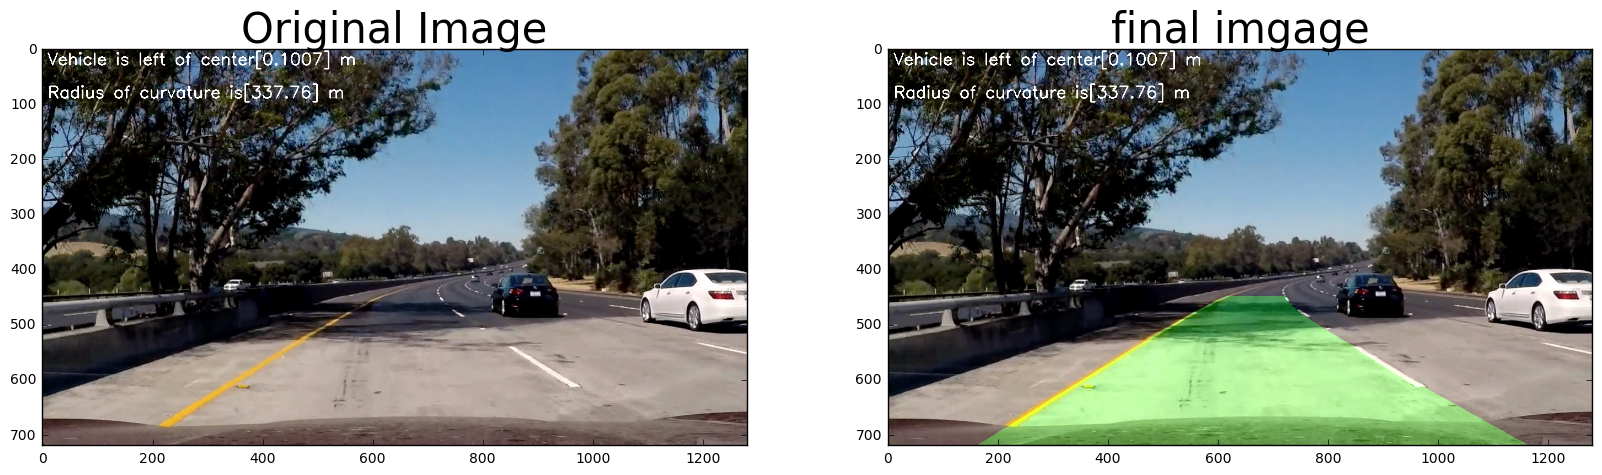

In [6]:
plot_double(img_test, result_test)

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

/home/ubuntu/anaconda3/envs/udacitypython3/lib/python3.5/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


In [8]:
output_project = 'project_video_result.mp4'
clip3 = VideoFileClip("project_video.mp4")
project_clip = clip3.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(output_project, audio=False)


MoviePy: building video file project_video_result.mp4
----------------------------------------

Writing video into project_video_result.mp4
|----------| 0/1210   0% [elapsed: 00:00 left: ?, ? iters/sec]

/home/ubuntu/anaconda3/envs/udacitypython3/lib/python3.5/site-packages/moviepy/audio/io/readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))
/home/ubuntu/anaconda3/envs/udacitypython3/lib/python3.5/site-packages/ipykernel/__main__.py:223: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/ubuntu/anaconda3/envs/udacitypython3/lib/python3.5/site-packages/ipykernel/__main__.py:223: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


                                                                         --------| 10/1210   0% [elapsed: 00:01 left: 02:02,  9.76 iters/sec]Done writing video in project_video_result.mp4 !
Your video is ready !
CPU times: user 3min 51s, sys: 9.96 s, total: 4min 1s
Wall time: 1min 54s


In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_project))